In [4]:
##imports and setup
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img, NumpyArrayIterator
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model
import cv2 as cv
import keras
from keras.applications import vgg16
from keras.models import Model

#mount drive:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#The model "starts" here:

def add_top_layer(model_base,output_classes):
  bottom_model = model_base.output
  """creates the top or head of the model that will be 
  placed ontop of the bottom layers"""
  bottom_model = Flatten(name="flatten")(bottom_model)
  bottom_model = Dense(1024,activation='relu')(bottom_model)
  bottom_model = Dropout(0.50)(bottom_model)
  bottom_model = Dense(1024,activation='relu')(bottom_model)
  bottom_model = Dropout(0.50)(bottom_model)
  bottom_model = Dense(512,activation='relu')(bottom_model)
  bottom_model = Dropout(0.50)(bottom_model)
  bottom_model = Dense(output_classes,activation='sigmoid')(bottom_model)

  return bottom_model
  #print(model.summary())
print('completed')


completed


In [8]:
###Input dimensions
IMG_SIZE = 128
IMG_DIM = 3

#loading the pretrained network.
model_base = vgg16.VGG16(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,IMG_DIM))
#print(model.summary())
#Keeping the weights from the trained network.
for layers in model_base.layers:
  layers.trainable = False
## adding the regression layer on top
model_head=add_top_layer(model_base,2)
#Connecting the two models
model=Model(inputs=model_base.input,outputs=model_head)
keras.backend.set_epsilon(1) #Used for mape
opt = Adam(lr=0.0001, decay=1e-6)
#Selecting loss and metrics
model.compile(optimizer=opt, loss='MSE', metrics=['mse', 'mape'])
#print(model.summary())
print('completed')

completed


In [ ]:
#Loading the Data_set
# Change data_src variable as per your drive
data_src = '/content/drive/MyDrive/Colab/afew'
size = 34947
#Loading the data into the correct format:
train_faces = np.load(data_src+'/arr_faces.npy')
train_cont = (np.load(data_src+'/arr_anno.npy')+10)/20
#Only for grayscale.
#train_faces=np.reshape(train_faces,(train_faces.shape[0],train_faces.shape[1],train_faces.shape[2],1))

#normalizing
#train_cont = (np.load(data_src+'/train_annotation_2.npy')+1)/2

#validation_cont =  (np.load(data_src+'/validation_annotation_2.npy')+1)/2

print(train_cont.shape)
print(train_faces.shape)
print('completed')

(19751, 2)
(19751, 128, 128, 3)
completed


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


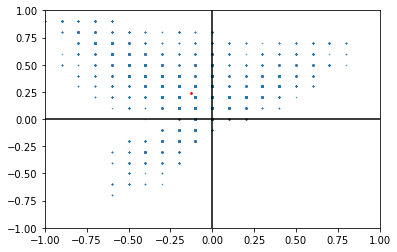

In [ ]:
#dataset investigation
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.scatter(train_cont[:,0]*2-1,train_cont[:,1]*2-1,s=0.2)
ax.scatter(np.mean(train_cont[:,0])*2-1,np.mean(train_cont[:,1])*2-1,s=3,c=(1,0,0))
fig.show()
#print(np.mean(train_cont[:,0]))
#print(np.mean(train_cont[:,1]))


In [ ]:
## Putting the data into training classes:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(train_faces, train_cont, test_size=0.20, shuffle= True)
faces=None
cont=None
##Try it out with a larger batch size
batch_size=64
#### Fit the dataset
train_datagen = ImageDataGenerator(rescale=1./255,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

training_set=train_datagen.flow(x_train,y_train,batch_size=batch_size)


val_datagen = ImageDataGenerator(rescale=1./255,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

val_set=val_datagen.flow(x_valid,y_valid,batch_size=batch_size)

print('completed')

completed


In [ ]:
###making the training ready
PATH="/content/drive/MyDrive/Colab/afew/"
chk_path = PATH+'model_vgg_afew.h5'
log_dir = PATH+"checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                               save_best_only=True,
                               verbose=1,
                               mode='min',
                               moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=3,
                            verbose=1,
                            restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=6,
                                verbose=1,
                                min_delta=0.0001)

steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = val_set.n // val_set.batch_size

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger(PATH+'training_augmented.log')

callback = [checkpoint, reduce_lr, csv_logger]
print(steps_per_epoch)
print(validation_steps)

print('completed')

246
61
completed


In [ ]:
with tf.device('/device:GPU:0'):
  epochs=40
  model_hist = model.fit(x=training_set,
                  validation_data=val_set,
                  epochs=epochs,
                  callbacks=callback,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps)
save_path = PATH+'model_vgg_afew_finished.h5'
model.save_weights(save_path)

Epoch 1/40
246/246 [==============================] - 111s 301ms/step - loss: 0.0317 - mse: 0.0317 - mape: 13.6584 - val_loss: 0.0160 - val_mse: 0.0160 - val_mape: 9.5741

Epoch 00001: val_loss improved from inf to 0.01600, saving model to /content/drive/MyDrive/Colab/afew/model_vgg_afew.h5
Epoch 2/40
246/246 [==============================] - 71s 288ms/step - loss: 0.0155 - mse: 0.0155 - mape: 9.4700 - val_loss: 0.0131 - val_mse: 0.0131 - val_mape: 8.6102

Epoch 00002: val_loss improved from 0.01600 to 0.01305, saving model to /content/drive/MyDrive/Colab/afew/model_vgg_afew.h5
Epoch 3/40
246/246 [==============================] - 71s 287ms/step - loss: 0.0130 - mse: 0.0130 - mape: 8.5994 - val_loss: 0.0096 - val_mse: 0.0096 - val_mape: 7.3468

Epoch 00003: val_loss improved from 0.01305 to 0.00960, saving model to /content/drive/MyDrive/Colab/afew/model_vgg_afew.h5
Epoch 4/40
246/246 [==============================] - 71s 287ms/step - loss: 0.0110 - mse: 0.0110 - mape: 7.9580 - val_l

<class 'list'>


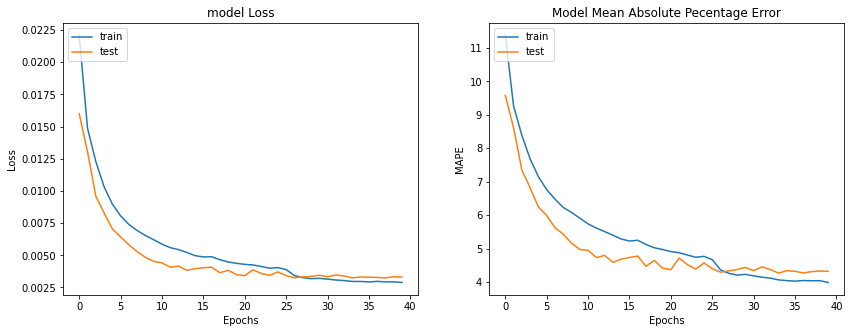

<Figure size 432x288 with 0 Axes>

In [ ]:
###Results for the model
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
print(type(model_hist.history['mse']))

plt.plot(model_hist.history['mape'])
plt.plot(model_hist.history['val_mape'])
plt.title('Model Mean Absolute Pecentage Error')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)

plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(PATH+"test_vgg_pretrained_afew.png")

In [9]:
##Loading weigths 
PATH="/content/drive/MyDrive/Colab/afew/"
# Load the previously saved weights
model.load_weights(PATH+'model_vgg_afew_finished.h5')
print('completed')

completed


In [10]:
def extract_face(frame ):
    # extracting face and body and outputs tensor # add size of output image
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.3, 6)
    # extract ROIS
    if type(faces) is tuple:
        return False
    for (x, y, w, h) in faces:
        # cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        ##simple scalings...
        # cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        ##simple scalings...
        start = int(y - 0.25 * h)
        if start < 0:
            start = 0
        leftbottom=int(y +1.25*h)
        if leftbottom>576:
            leftbottom=576
        topright=int(x-w*0.25)
        if topright<0:
            topright=0
        bottom_right=int(x +1.25*w)
        if bottom_right>720:
            bottom_right=720
        roi = frame[start:leftbottom, topright:bottom_right]
    dim = (128, 128)
    resized = cv.resize(roi, dim, interpolation=cv.INTER_AREA)
    # print(resized.shape)
    #cv.imshow("frame",resized)
    return resized
print("completed")

completed


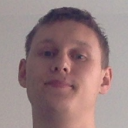

[[-0.13305587  0.19917262]]


In [14]:
import cv2 as cv
from google.colab.patches import cv2_imshow
##Testing

PATH_IMAGE = "/content/drive/MyDrive/Colab/emotion_pics/"
image = "body.jpg"
frame=cv.imread(PATH_IMAGE+image)
img=extract_face(frame)
cv2_imshow(img)

#img=np.resize(img,(img.shape[0],img.shape[1],1))
#print(train_cont)
#print(train_faces)
#indexes=np.nonzero(train_faces < 0.1)
#cv2_imshow(train_faces[9300])
with tf.device('/device:GPU:0'):
  #predicted=model.predict(train_faces[9300][None,...]/255)
  predicted=model.predict(img[None,...]/255)
  #print(predicted)
  #print(train_cont[6])
predicted=predicted*2-1
print(predicted)
#print(train_cont[9300])


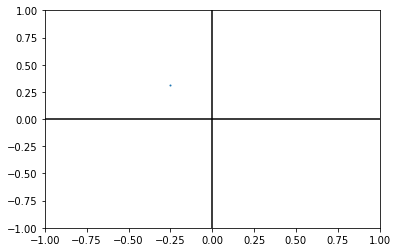

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.scatter(predicted[0][0],predicted[0][1],s=1)
#ax.scatter(np.mean(cont[:,0])*2-1,np.mean(cont[:,1])*2-1,s=3,c=(1,0,0))
fig.show()